# Compression Pipeline:


<div style="background-color: white; padding: 10px;">
    <img src="./docs/static/img/pipeline.svg" alt="SVG Image" width="1500px" />
</div>

Instead of running the compression pipeline all at once, here you can run it step-by-step and explore the process.

## First simulate the command-line arguments

In [1]:
simulated_args = [
        "--model_path", "./input_models/flower_hq",
        "--data_device", "cuda",
        "--output_vq", "./output"
]

In [2]:
# General
import time
import os
from os import path
from shutil import copyfile
import gc
import json

# Data
import torch
import numpy as np
from tqdm import trange

# Visualisations
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Arguments
from argparse import ArgumentParser, Namespace
from arguments import (
    CompressionParams,
    ModelParams,
    OptimizationParams,
    PipelineParams,
    get_combined_args,
)

# c3dgs functions / classes
from compress import unique_output_folder, calc_importance
from gaussian_renderer import GaussianModel
from scene import Scene
from compression.vq import CompressionSettings
from typing import Tuple
from utils.splats import to_full_cov, extract_rot_scale
from compression.vq import VectorQuantize, join_features

In [3]:
def parse_arguments(simulated_args=[]):
    # Initialize the argument parser
    parser = ArgumentParser(description="Compression script parameters")
    
    # Add the same argument groups as in the script
    model = ModelParams(parser, sentinel=True)
    model.data_device = "cuda"
    pipeline = PipelineParams(parser)
    op = OptimizationParams(parser)
    comp = CompressionParams(parser)
    
    # Combine simulated args with parser arguments
    args = get_combined_args(parser, simulated_args)
    return args, model, pipeline, op, comp


args, model, pipeline, op, comp = parse_arguments(simulated_args)

# Set output folder if not specified
if args.output_vq is None:
    args.output_vq = unique_output_folder()

# Extract parameters
model_params = model.extract(args)
optim_params = op.extract(args)
pipeline_params = pipeline.extract(args)
comp_params = comp.extract(args)

Looking for config file in ./input_models/flower_hq/cfg_args
Config file found: ./input_models/flower_hq/cfg_args


In [4]:
# Initialize the Gaussians
gaussians = GaussianModel(
    model_params.sh_degree, quantization=not optim_params.not_quantization_aware
)

# Initialize the scene (test cameras + train cameras)
scene = Scene(
    model_params, gaussians, load_iteration=comp_params.load_iteration, shuffle=True
)

# Load the Gaussians from the pre-trained model (checkpoint) into memory
if comp_params.start_checkpoint:
    (checkpoint_params, first_iter) = torch.load(comp_params.start_checkpoint)
    gaussians.restore(checkpoint_params, optim_params)


timings = {}

Loading trained model at iteration 30000
Reading camera 173/173
Loading Training Cameras
Loading Test Cameras


## Step 1: Parameter Sensitivity
Note: The authors use 'sensitivity' and 'importance' interchangeably, this is very confusing I know 

In [5]:
# Important hyperparameters                                     # Default value
comp_params.color_importance_include                            # 0.6*1e-6
comp_params.gaussian_importance_include                         # 0.3*1e-5

3e-06

In [6]:
start_time = time.time()

color_importance, gaussian_sensitivity = calc_importance(
    gaussians, scene, pipeline_params
)
end_time = time.time()
timings["sensitivity_calculation"] = end_time-start_time

Calculating sensitivity: 100%|██████████| 173/173 [00:05<00:00, 32.75it/s]


In [7]:
color_importance_include = torch.tensor(comp_params.color_importance_include)
gaussian_importance_include = torch.tensor(comp_params.gaussian_importance_include)

color_above_threshold = (color_importance > color_importance_include).sum().item()
total_elements_color = color_importance.numel()

gaussian_above_threshold = (gaussian_sensitivity > gaussian_importance_include).sum().item()
total_elements_gaussian = gaussian_sensitivity.numel()

color_threshold = 1.0 - (color_above_threshold / total_elements_color)
gaussian_threshold = 1.0 - (gaussian_above_threshold / total_elements_gaussian)

print(f"Percentage of color_importance values below the threshold: {color_threshold * 100:.2f}%")
print(f"Percentage of gaussian_importance values below the threshold: {gaussian_threshold * 100:.2f}%")

Percentage of color_importance values below the threshold: 98.37%
Percentage of gaussian_importance values below the threshold: 98.29%


In [8]:
# Normalize the tensors
color_importance_norm = torch.nn.functional.normalize(color_importance.clone(), p=2)
gaussian_sensitivity_norm = torch.nn.functional.normalize(gaussian_sensitivity.clone(), p=2)

# # Normalize the tensors
# color_importance_norm = color_importance / color_importance.max()
# gaussian_sensitivity_norm = gaussian_sensitivity / gaussian_sensitivity.max()

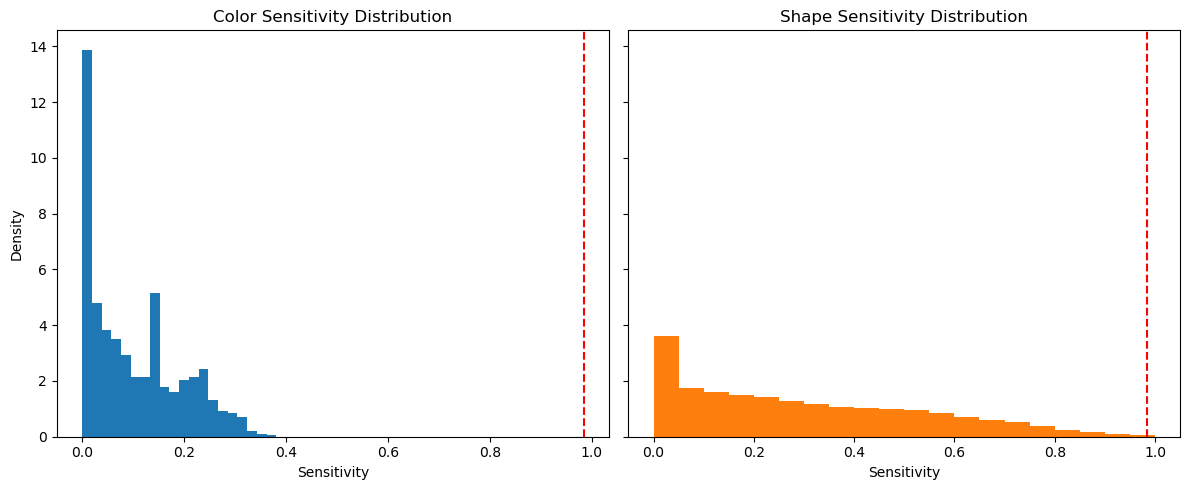

In [9]:
color_importance_norm_np = color_importance_norm.cpu().numpy().flatten()  # Convert to numpy array if needed
gaussian_sensitivity_norm_np = gaussian_sensitivity_norm.cpu().numpy().flatten()
# color_threshold = color_importance_include.cpu().numpy()
# gaussian_threshold = gaussian_importance_include.cpu().numpy()

# color_importance = color_importance.flatten()  # Convert to numpy array if needed
# gaussian_sensitivity = gaussian_sensitivity.flatten()


# Define the number of bins
num_bins = 20

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Color sensitivity histogram
axes[0].hist(
    color_importance_norm_np,
    bins=num_bins,
    color="#1f77b4",
    density=True
)
axes[0].axvline(color_threshold, color='red', linestyle='--', label=f'Threshold ({color_threshold})')
axes[0].set_title("Color Sensitivity Distribution")
axes[0].set_xlabel("Sensitivity")
axes[0].set_ylabel("Density")
# axes[0].set_yscale("log")

# Shape sensitivity histogram
axes[1].hist(
    gaussian_sensitivity_norm_np,
    bins=num_bins,
    color="#ff7f0e",
    density=True
)
axes[1].axvline(gaussian_threshold, color='red', linestyle='--', label=f'Threshold ({gaussian_threshold})')
axes[1].set_title("Shape Sensitivity Distribution")
axes[1].set_xlabel("Sensitivity")

plt.tight_layout()
plt.show()

## Step 2: Sensitivity-aware vector clustering
Note: vector clustering = vector quantization = K-Means clustering

In [10]:
def prune_gaussians(
    gaussians: GaussianModel,
    color_importance_n: torch.Tensor,
    gaussian_importance_n: torch.Tensor,
    prune_threshold:float=0.,
):
    with torch.no_grad():
        if prune_threshold >= 0:
            non_prune_mask = color_importance_n > prune_threshold
            print(f"prune: {(1-non_prune_mask.float().mean())*100:.2f}%")
            gaussians.mask_splats(non_prune_mask)
            gaussian_importance_n = gaussian_importance_n[non_prune_mask]
            color_importance_n = color_importance_n[non_prune_mask]
        
        # if prune_threshold >= 0:
        #     non_prune_mask = color_importance_n > prune_threshold
        #     prune_percentage = (1 - non_prune_mask.float().mean()) * 100

        #     gaussians.mask_splats(non_prune_mask)
        #     gaussian_importance_n = gaussian_importance_n[non_prune_mask]
        #     color_importance_n = color_importance_n[non_prune_mask]

            # # Get positions for each Gaussian
            # positions = gaussians.get_xyz
            
            # # Separate the positions and sensitivities based on pruning mask
            # pos_keep = positions[non_prune_mask].cpu().numpy()
            # pos_prune = positions[~non_prune_mask].cpu().numpy()

            # fig = go.Figure()

            # # Scatter plot for Gaussians that will be kept
            # fig.add_trace(go.Scatter3d(
            #     x=pos_prune[:, 0],
            #     y=pos_prune[:, 1],
            #     z=pos_prune[:, 2],
            #     mode='markers',
            #     marker=dict(
            #         size=3,
            #         color='red',    
            #         opacity=0.5,
            #     ),
            #     name="Pruned Gaussians"
            # ))

            # # Scatter plot for Gaussians that will be pruned
            # fig.add_trace(go.Scatter3d(
            #     x=pos_keep[:, 0],
            #     y=pos_keep[:, 1],
            #     z=pos_keep[:, 2],
            #     mode='markers',
            #     marker=dict(
            #         size=3,
            #         color='blue',
            #         opacity=0.7,
            #     ),
            #     name="Kept Gaussians"
            # ))

            # title = f"Pruning {prune_percentage:.2f}% of Gaussians"
            # fig.update_layout(
            #     title=title,
            #     scene=dict(
            #         xaxis_title="X",
            #         yaxis_title="Y",
            #         zaxis_title="Z",
            #     ),
            #     legend=dict(x=1, y=0.9)
            # )

            # fig.show()


# TODO: Use point cloud RGB color instead of 'blue'

# from plyfile import PlyData
# import numpy as np
# import plotly.graph_objects as go
# import matplotlib.colors as mcolors

# # Load points3d.ply
# ply_path = "./datasets/flowers/sparse/0/points3D.ply"
# plydata = PlyData.read(ply_path)

# # Extract positions and colors
# # positions_ply = np.vstack([plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']]).T
# colors_ply = np.vstack([plydata['vertex']['red'], plydata['vertex']['green'], plydata['vertex']['blue']]).T

# def prune_gaussians(
#     gaussians: GaussianModel,
#     color_importance: torch.Tensor,
#     gaussian_importance: torch.Tensor,
#     prune_threshold: float = 0.,
# ):
#     with torch.no_grad():
#         if prune_threshold >= 0:
#             non_prune_mask = color_importance > prune_threshold
#             prune_percentage = (1 - non_prune_mask.float().mean()) * 100

#             # Get positions and colors for each Gaussian
#             positions = gaussians.get_xyz
#             # colors = gaussians._features_dc  # Assuming _features_dc holds the RGB color

#             # Separate the positions and colors based on pruning mask
#             pos_keep = positions[non_prune_mask].cpu().numpy()
#             pos_prune = positions[~non_prune_mask].cpu().numpy()
#             color_keep = colors_ply[non_prune_mask.cpu().numpy()]  # Colors for kept Gaussians

#             # Normalize colors to range [0, 1] if necessary
#             if color_keep.max() > 1:
#                 color_keep = color_keep / 255.0

#             color_keep = np.clip(color_keep, 0, 1)

#             # Convert RGB colors to hex format for plotly
#             color_keep_hex = [mcolors.to_hex(c) for c in color_keep]

#             fig = go.Figure()

#             # Scatter plot for Gaussians that will be pruned
#             fig.add_trace(go.Scatter3d(
#                 x=pos_prune[:, 0],
#                 y=pos_prune[:, 1],
#                 z=pos_prune[:, 2],
#                 mode='markers',
#                 marker=dict(
#                     size=3,
#                     color='red',    
#                     opacity=0.5,
#                 ),
#                 name="Pruned Gaussians"
#             ))

#             # Scatter plot for Gaussians that will be kept, using actual colors
#             fig.add_trace(go.Scatter3d(
#                 x=pos_keep[:, 0],
#                 y=pos_keep[:, 1],
#                 z=pos_keep[:, 2],
#                 mode='markers',
#                 marker=dict(
#                     size=3,
#                     color=color_keep_hex,  # Use hex colors for kept Gaussians
#                     opacity=0.7,
#                 ),
#                 name="Kept Gaussians"
#             ))

#             title = f"Pruning {prune_percentage:.2f}% of Gaussians"
#             fig.update_layout(
#                 title=title,
#                 scene=dict(
#                     xaxis_title="X",
#                     yaxis_title="Y",
#                     zaxis_title="Z",
#                 ),
#                 legend=dict(x=1, y=0.9)
#             )

#             fig.show()

# import plotly.graph_objects as go
# import matplotlib.colors as mcolors

# def prune_gaussians(
#     gaussians: GaussianModel,
#     color_importance: torch.Tensor,
#     gaussian_importance: torch.Tensor,
#     prune_threshold: float = 0.,
# ):
#     with torch.no_grad():
#         if prune_threshold >= 0:
#             non_prune_mask = color_importance > prune_threshold
#             prune_percentage = (1 - non_prune_mask.float().mean()) * 100

#             # Get positions and colors for each Gaussian
#             positions = gaussians.get_xyz
#             colors = gaussians._features_dc  # Assuming _features_dc holds the RGB color

#             # Separate the positions and colors based on pruning mask
#             pos_keep = positions[non_prune_mask].cpu().numpy()
#             pos_prune = positions[~non_prune_mask].cpu().numpy()
#             color_keep = colors[non_prune_mask].cpu().numpy()  # Colors for kept Gaussians

#             # Ensure color_keep values are within the [0, 1] range
#             color_keep = np.clip(color_keep, 0, 1)  # Clip any values outside [0, 1]

#             # Convert RGB colors to hex format for plotly
#             color_keep_hex = [mcolors.to_hex(c) for c in color_keep]

#             fig = go.Figure()

#             # Scatter plot for Gaussians that will be pruned
#             fig.add_trace(go.Scatter3d(
#                 x=pos_prune[:, 0],
#                 y=pos_prune[:, 1],
#                 z=pos_prune[:, 2],
#                 mode='markers',
#                 marker=dict(
#                     size=3,
#                     color='red',    
#                     opacity=0.5,
#                 ),
#                 name="Pruned Gaussians"
#             ))

#             # Scatter plot for Gaussians that will be kept, using actual colors
#             fig.add_trace(go.Scatter3d(
#                 x=pos_keep[:, 0],
#                 y=pos_keep[:, 1],
#                 z=pos_keep[:, 2],
#                 mode='markers',
#                 marker=dict(
#                     size=3,
#                     color=color_keep_hex,  # Use hex colors for kept Gaussians
#                     opacity=0.7,
#                 ),
#                 name="Kept Gaussians"
#             ))

#             title = f"Pruning {prune_percentage:.2f}% of Gaussians"
#             fig.update_layout(
#                 title=title,
#                 scene=dict(
#                     xaxis_title="X",
#                     yaxis_title="Y",
#                     zaxis_title="Z",
#                 ),
#                 legend=dict(x=1, y=0.9)
#             )

#             fig.show()

#             # Actually prune
#             # gaussians.mask_splats(non_prune_mask)
#             # gaussian_importance = gaussian_importance[non_prune_mask]
#             # color_importance = color_importance[non_prune_mask]


------------------ Pruning ------------------

In [11]:
# Important hyperparameters                                     # Default value
comp_params.prune_threshold                                     # 0.0

0.0

In [12]:
with torch.no_grad():
    start_time = time.time()

    # Given a vector x ∈ R^D, we define its sensitivity as the maximum over its component’s sensitivity
    color_importance_n = color_importance.amax(-1)
    gaussian_importance_n = gaussian_sensitivity.amax(-1)

    torch.cuda.empty_cache()

    # ------------------ Prune ------------------
    prune_threshold = comp_params.prune_threshold

    if prune_threshold >= 0:
        non_prune_mask = color_importance_n > prune_threshold

        # # Get positions for each Gaussian
        # positions = gaussians.get_xyz
        
        # # Separate the positions and sensitivities based on pruning mask
        # pos_keep = positions[non_prune_mask].cpu().numpy()
        # pos_prune = positions[~non_prune_mask].cpu().numpy()

        # fig = go.Figure()

        # # Scatter plot for Gaussians that will be kept
        # fig.add_trace(go.Scatter3d(
        #     x=pos_prune[:, 0],
        #     y=pos_prune[:, 1],
        #     z=pos_prune[:, 2],
        #     mode='markers',
        #     marker=dict(
        #         size=3,
        #         color='red',    
        #         opacity=0.5,
        #     ),
        #     name="Pruned Gaussians"
        # ))

        # # Scatter plot for Gaussians that will be pruned
        # fig.add_trace(go.Scatter3d(
        #     x=pos_keep[:, 0],
        #     y=pos_keep[:, 1],
        #     z=pos_keep[:, 2],
        #     mode='markers',
        #     marker=dict(
        #         size=3,
        #         color='blue',
        #         opacity=0.7,
        #     ),
        #     name="Kept Gaussians"
        # ))

        # prune_percentage = (1 - non_prune_mask.float().mean()) * 100

        # title = f"Pruning {prune_percentage:.2f}% of Gaussians"
        # fig.update_layout(
        #     title=title,
        #     scene=dict(
        #         xaxis_title="X",
        #         yaxis_title="Y",
        #         zaxis_title="Z",
        #     ),
        #     legend=dict(x=1, y=0.9)
        # )

        # fig.show()

        gaussians.mask_splats(non_prune_mask)
        gaussian_importance_n = gaussian_importance_n[non_prune_mask]
        color_importance_n = color_importance_n[non_prune_mask]

------------------ Color Compression ------------------

In [13]:
# Important hyperparameters                                     # Default value
comp_params.color_codebook_size                                 # 2**12
# comp_params.color_cluster_iterations                            # 100
comp_params.color_cluster_iterations = 1 # TODO: remove
comp_params.color_decay                                         # 0.8
comp_params.color_batch_size                                    # 2**18

# Initialize the color codebook using parameters
color_compression_settings = CompressionSettings(
    codebook_size=comp_params.color_codebook_size,
    importance_prune=comp_params.color_importance_prune,
    importance_include=comp_params.color_importance_include,
    steps=int(comp_params.color_cluster_iterations),
    decay=comp_params.color_decay,
    batch_size=comp_params.color_batch_size,
)

In [14]:
def animate_clustering(features, centroids_history, title="Color Features Clustering Animation"):
    # Reduce features to 2D for plotting
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features.cpu().numpy())
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot of features (fixed throughout the animation)
    ax.scatter(features_2d[:, 0], features_2d[:, 1], s=1, alpha=0.5, color='blue', label="Features")
    
    # Initial scatter plot for centroids (updated in each frame)
    centroids_2d = pca.transform(centroids_history[0])  # Initial centroids
    centroids_plot, = ax.plot(centroids_2d[:, 0], centroids_2d[:, 1], 'ro', markersize=1, label="Centroids")

    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend()

    def update(frame):
        # Update centroids plot in each frame
        centroids_2d = pca.transform(centroids_history[frame])
        centroids_plot.set_data(centroids_2d[:, 0], centroids_2d[:, 1])
        ax.set_title(f"{title} - Iteration {frame + 1}")
        return centroids_plot,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(centroids_history), interval=500, blit=True)
    # plt.show()
    display(HTML(ani.to_jshtml()))

    return ani

def animate_clustering2(features, centroids_history, title="Color Features Clustering Animation"):
    pca = PCA(n_components=2)
    
    features_2d = pca.fit_transform(features)
    centroids_2d_history = [pca.fit_transform(centroids) for centroids in centroids_history]

    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot of features (fixed throughout the animation)
    ax.scatter(features_2d[:, 0], features_2d[:, 1], s=1, alpha=0.5, color='blue', label="Features")
    
    # Initial scatter plot for centroids (updated in each frame)
    centroids_plot, = ax.plot(centroids_2d_history[0][:, 0], centroids_2d_history[0][:, 1], 'ro', markersize=1, label="Centroids")

    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend()

    def update(frame):
        # Update centroids plot in each frame
        centroids_2d = centroids_2d_history[frame]
        centroids_plot.set_data(centroids_2d[:, 0], centroids_2d[:, 1])
        ax.set_title(f"{title} - Iteration {frame + 1}")
        return centroids_plot,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(centroids_2d_history), interval=500, blit=True)
    display(HTML(ani.to_jshtml()))

    return ani

In [15]:
def plot_features_and_compressed(color_features, compressed_features, title="Original and Compressed Features"):
    # Reduce features to 2D using PCA for visualization
    pca = PCA(n_components=2)
    all_features_2d = pca.fit_transform(color_features.cpu().numpy())
    compressed_features_2d = pca.transform(compressed_features.cpu().numpy())

    # Plot all features and compressed features
    plt.figure(figsize=(10, 8))
    plt.scatter(all_features_2d[:, 0], all_features_2d[:, 1], s=1, alpha=0.5, color='blue', label="All Features")
    plt.scatter(compressed_features_2d[:, 0], compressed_features_2d[:, 1], s=1, color='red', label="Compressed Features")
    
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

def plot_features_and_compressed2(color_features, compressed_features, title="Original and Compressed Features"):
    # Reduce features to 2D using PCA for visualization
    pca = PCA(n_components=2)
    all_features_2d = pca.fit_transform(color_features)
    compressed_features_2d = pca.transform(compressed_features.cpu().numpy())

    # Plot all features and compressed features
    plt.figure(figsize=(10, 8))
    plt.scatter(all_features_2d[:, 0], all_features_2d[:, 1], s=1, alpha=0.5, color='blue', label="All Features")
    plt.scatter(compressed_features_2d[:, 0], compressed_features_2d[:, 1], s=1, color='red', label="Compressed Features")
    
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

In [16]:
def vq_features_vis(
    features: torch.Tensor,
    importance: torch.Tensor,
    codebook_size: int,
    vq_chunk: int = 2**16,
    steps: int = 1000,
    decay: float = 0.8,
    scale_normalize: bool = False,
) -> Tuple[torch.Tensor, torch.Tensor]:
    importance_n = importance/importance.max()
    vq_model = VectorQuantize(
        channels=features.shape[-1],
        codebook_size=codebook_size,
        decay=decay,
    ).to(device=features.device)

    vq_model.uniform_init(features)

    errors = []
    centroids_history = [vq_model.codebook.data.cpu().numpy().copy()] # Store the initial centroids

    for i in trange(steps):
        batch = torch.randint(low=0, high=features.shape[0], size=[vq_chunk])
        vq_feature = features[batch]
        error = vq_model.update(vq_feature, importance=importance_n[batch]).mean().item()
        errors.append(error)

        # Store centroids every 5th iteration
        if (i + 1) % 5 == 0:
            centroids_history.append(vq_model.codebook.data.cpu().numpy().copy())

        if scale_normalize:
            # this computes the trace of the codebook covariance matrices
            # we devide by the trace to ensure that matrices have normalized eigenvalues / scales
            tr = vq_model.codebook[:, [0, 3, 5]].sum(-1)
            vq_model.codebook /= tr[:, None]

    gc.collect()
    torch.cuda.empty_cache()

    start = time.time()
    _, vq_indices = vq_model(features)
    torch.cuda.synchronize(device=vq_indices.device)
    end = time.time()
    print(f"calculating indices took {end-start} seconds ")
    return vq_model.codebook.data.detach(), vq_indices.detach(), errors, centroids_history

In [17]:
def compress_color_vis(
    gaussians: GaussianModel,
    color_importance_n: torch.Tensor,
    color_comp: CompressionSettings,
    color_compress_non_dir: bool,
):
    keep_mask = color_importance_n > color_comp.importance_include

    print(f"color keep: {keep_mask.float().mean()*100:.2f}%")

    vq_mask_c = ~keep_mask

    # remove zero sh component
    if color_compress_non_dir:
        n_sh_coefs = gaussians.get_features.shape[1]
        color_features = gaussians.get_features.detach().flatten(-2)
    else:
        n_sh_coefs = gaussians.get_features.shape[1] - 1
        color_features = gaussians.get_features[:, 1:].detach().flatten(-2)

    if vq_mask_c.any():
        color_codebook, color_vq_indices, errors, centroids_history = vq_features_vis(
            color_features[vq_mask_c],
            color_importance_n[vq_mask_c],
            color_comp.codebook_size,
            color_comp.batch_size,
            color_comp.steps,
        )
    else:
        color_codebook = torch.empty(
            (0, color_features.shape[-1]), device=color_features.device
        )
        color_vq_indices = torch.empty(
            (0,), device=color_features.device, dtype=torch.long
        )

    all_features = color_features
    compressed_features, indices = join_features(
        all_features, keep_mask, color_codebook, color_vq_indices
    )

    gaussians.set_color_indexed(compressed_features.reshape(-1, n_sh_coefs, 3), indices)

    ani = animate_clustering(color_features, centroids_history, title="2D Projection of Color Features")

    return errors, ani, color_features, compressed_features

In [18]:
%matplotlib notebook

color_errors = []

with torch.no_grad():
    color_comp = color_compression_settings if not comp_params.not_compress_color else None
    if color_comp is not None:
        color_errors, ani, color_features, compressed_features = compress_color_vis(
            gaussians,
            color_importance_n,
            color_comp,
            comp_params.color_compress_non_dir,
        )

color keep: 5.52%


100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


calculating indices took 9.331032514572144 seconds 


<IPython.core.display.Javascript object>

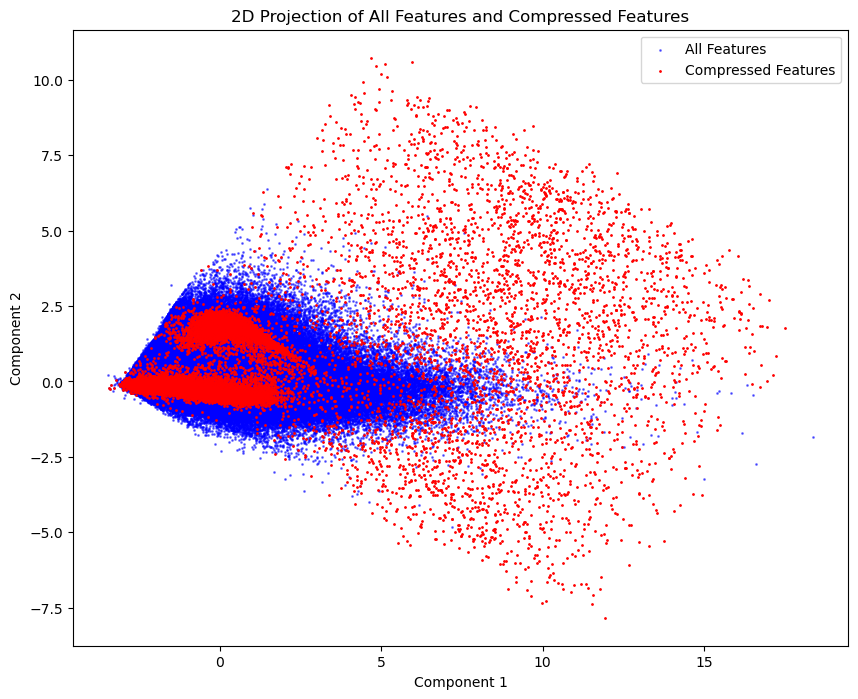

In [19]:
%matplotlib inline
plot_features_and_compressed(color_features, compressed_features, title="2D Projection of All Features and Compressed Features")

In [20]:
def plot_error_curve(errors=[]):
    plt.figure(figsize=(10, 6))
    plt.plot(errors, label='Quantization Error')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Quantization Error')
    plt.title('Quantization Error Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

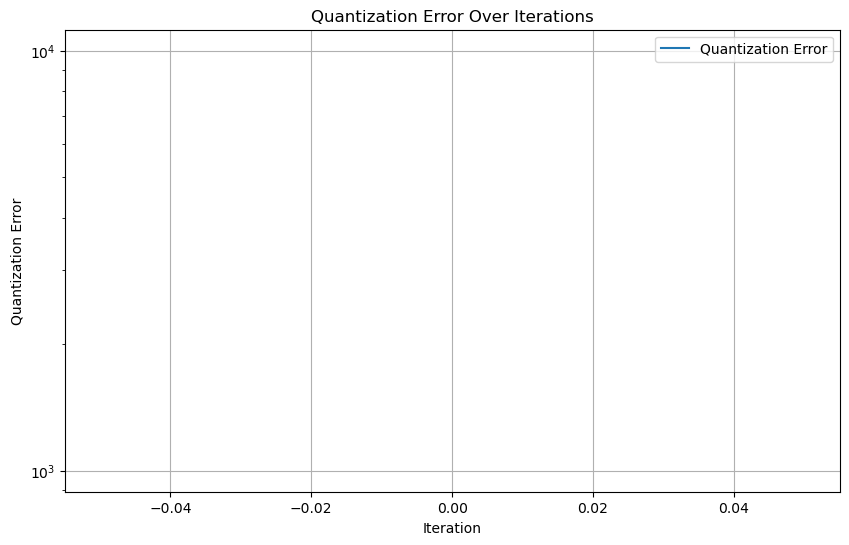

In [21]:
plot_error_curve(color_errors)

------------------ Gaussian Shape Compression ------------------

In [22]:
# Important hyperparameters                                     # Default value
comp_params.gaussian_codebook_size                              # 2**12
# comp_params.gaussian_cluster_iterations                         # 800
comp_params.gaussian_cluster_iterations = 1 # TODO: remove
comp_params.gaussian_decay                                      # 0.8
comp_params.gaussian_batch_size                                 # 2**20

# Initialize the Gaussian shape codebook using parameters
gaussian_compression_settings = CompressionSettings(
    codebook_size=comp_params.gaussian_codebook_size,
    importance_prune=None,
    importance_include=comp_params.gaussian_importance_include,
    steps=int(comp_params.gaussian_cluster_iterations),
    decay=comp_params.gaussian_decay,
    batch_size=comp_params.gaussian_batch_size,
)


# TODO: Experiment Gaussian importance prune

In [23]:
def compress_covariance_vis(
    gaussians: GaussianModel,
    gaussian_importance_n: torch.Tensor,
    gaussian_comp: CompressionSettings,
):

    keep_mask_g = gaussian_importance_n > gaussian_comp.importance_include

    vq_mask_g = ~keep_mask_g

    print(f"gaussians keep: {keep_mask_g.float().mean()*100:.2f}%")

    covariance = gaussians.get_normalized_covariance(strip_sym=True).detach()
    covariance_sym = gaussians.get_covariance(strip_sym=False).detach()

    if vq_mask_g.any():
        cov_codebook, cov_vq_indices, errors, centroids_history = vq_features_vis(
            covariance[vq_mask_g],
            gaussian_importance_n[vq_mask_g],
            gaussian_comp.codebook_size,
            gaussian_comp.batch_size,
            gaussian_comp.steps,
            scale_normalize=True,
        )
    else:
        cov_codebook = torch.empty(
            (0, covariance.shape[1], 1), device=covariance.device
        )
        cov_vq_indices = torch.empty((0,), device=covariance.device, dtype=torch.long)

    compressed_cov, cov_indices = join_features(
        covariance,
        keep_mask_g,
        cov_codebook,
        cov_vq_indices,
    )

    rot_vq, scale_vq = extract_rot_scale(to_full_cov(compressed_cov))

    gaussians.set_gaussian_indexed(
        rot_vq.to(compressed_cov.device),
        scale_vq.to(compressed_cov.device),
        cov_indices,
    )
    
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_sym.cpu().numpy())
    feature_vectors = eigenvalues[:, :3]

    threshold = np.percentile(feature_vectors, 95, axis=0)
    filtered_features = feature_vectors[np.all(feature_vectors <= threshold, axis=1)]
    
    filtered_centroids_history = []
    for centroids in centroids_history:
        centroid_threshold = np.percentile(centroids, 95, axis=0)  # Calculate 95th percentile threshold per centroid
        filtered_centroids = centroids[np.all(centroids <= centroid_threshold, axis=1)]
        filtered_centroids_history.append(filtered_centroids)

    # Run the animation function with filtered features and centroids
    ani = animate_clustering2(filtered_features, filtered_centroids_history, title="2D Projection of Gaussian Shape Features")


    # ani = animate_clustering(rot, centroids_history, title="2D Projection of Color Features")
    # ani = animate_clustering2(eigenvalues[:, :3], centroids_history, title="2D Projection of Color Features")

    return errors, ani, filtered_features, compressed_cov

In [24]:
%matplotlib notebook

shape_errors = []

with torch.no_grad():
    gaussian_comp = gaussian_compression_settings if not comp_params.not_compress_gaussians else None
    if gaussian_comp is not None:
        shape_errors, ani, filtered_features, compressed_cov = compress_covariance_vis(
            gaussians,
            gaussian_importance_n,
            gaussian_comp,
        )

end_time = time.time()
timings["clustering"]=end_time-start_time

gaussians keep: 4.08%


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


calculating indices took 1.0402390956878662 seconds 


<IPython.core.display.Javascript object>

^ Shows the high redundancy in shape features

In [25]:
# %matplotlib inline
# plot_features_and_compressed2(filtered_features, compressed_cov, title="2D Projection of All Features and Compressed Features")

In [26]:
plot_error_curve(shape_errors)

<IPython.core.display.Javascript object>

Before moving on to the finetuning step we have to prepare the output directory

In [27]:
# Clean up memory 
gc.collect()
torch.cuda.empty_cache()

# Create output directory
os.makedirs(comp_params.output_vq, exist_ok=True)

# Copy configuration file
copyfile(
    path.join(model_params.model_path, "cfg_args"),
    path.join(comp_params.output_vq, "cfg_args"),
)

# Update model path to point to new output directory
model_params.model_path = comp_params.output_vq

#  Save compression parameters in a new configuration file
with open(
    os.path.join(comp_params.output_vq, "cfg_args_comp"), "w"
) as cfg_log_f:
    cfg_log_f.write(str(Namespace(**vars(comp_params))))

## Step 3: Quantization-Aware Fine-Tuning

In [28]:
# Important hyperparameters                                     # Default value
# comp_params.finetune_iterations = 200
comp_params.finetune_iterations                                 # 5000

optim_params.lambda_dssim                                       # 0.2

0.2

In [29]:
def animate_rendered_images(rendered_images):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Initial image display
    img_display = ax.imshow(rendered_images[0])
    ax.set_title("Rendered Image Animation")

    def update(frame):
        img_display.set_data(rendered_images[frame])
        ax.set_title(f"Rendered Image - Frame {frame + 1}")
        return img_display,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(rendered_images), interval=500, blit=True)
    
    display(HTML(ani.to_jshtml()))
    
    return ani

In [30]:
from finetune import prepare_output_and_logger
from tqdm import tqdm
from gaussian_renderer import render
from random import randint
from utils.loss_utils import l1_loss,  ssim


def finetune_vis(scene: Scene, vis_cam, dataset, opt, comp, pipe, testing_iterations, debug_from):
    prepare_output_and_logger(comp.output_vq, dataset)

    first_iter = scene.loaded_iter
    max_iter = first_iter + comp.finetune_iterations

    bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    iter_start = torch.cuda.Event(enable_timing=True)
    iter_end = torch.cuda.Event(enable_timing=True)

    scene.gaussians.training_setup(opt)
    scene.gaussians.update_learning_rate(first_iter)

    viewpoint_stack = None
    ema_loss_for_log = 0.0
    progress_bar = tqdm(range(first_iter, max_iter), desc="Training progress")
    first_iter += 1


    # Store intermediate renderings for visualisation
    rendering = render(vis_cam, scene.gaussians, pipe, background)["render"]
    rendered_images = [rendering.detach().cpu().numpy().transpose(1, 2, 0)]

    losses = []


    for iteration in range(first_iter, max_iter + 1):
        iter_start.record()

        # Pick a random Camera
        if not viewpoint_stack:
            viewpoint_stack = scene.getTrainCamerasExceptVis().copy()
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack) - 1))

        # Render
        if (iteration - 1) == debug_from:
            pipe.debug = True
        
        render_pkg = render(viewpoint_cam, scene.gaussians, pipe, background)
        image, viewspace_point_tensor, visibility_filter, radii = (
            render_pkg["render"],
            render_pkg["viewspace_points"],
            render_pkg["visibility_filter"],
            render_pkg["radii"],
        )

        # Loss
        gt_image = viewpoint_cam.original_image.cuda()

        Ll1 = l1_loss(image, gt_image)
        loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (
            1.0 - ssim(image, gt_image)
        )
        loss.backward()

        losses.append(loss.detach().cpu())

        iter_end.record()
        scene.gaussians.update_learning_rate(iteration)

        with torch.no_grad():
            # Progress bar
            ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
            if iteration % 10 == 0:
                progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
                progress_bar.update(10)
            if iteration == max_iter:
                progress_bar.close()

            # Optimizer step
            if iteration < max_iter:
                scene.gaussians.optimizer.step()
                scene.gaussians.optimizer.zero_grad()

            # Visualisation
            if (iteration + 1) % 100 == 0:
                rendering = render(vis_cam, scene.gaussians, pipe, background)["render"]
                rendered_images.append(rendering.detach().cpu().numpy().transpose(1, 2, 0))

    ani = animate_rendered_images(rendered_images)
    return ani, losses

In [32]:
%matplotlib notebook
# %matplotlib inline

iteration = scene.loaded_iter + comp_params.finetune_iterations

if comp_params.finetune_iterations > 0:

    start_time = time.time()

    vis_cam = scene.getVisCamera()

    ani, losses = finetune_vis(
        scene,
        vis_cam,
        model_params,
        optim_params,
        comp_params,
        pipeline_params,
        testing_iterations=[-1],
        debug_from=-1,
    )
    
    end_time = time.time()
    timings["finetune"]=end_time-start_time

Output folder: ./output


Training progress: 100%|██████████| 5000/5000 [05:37<00:00, 14.82it/s, Loss=0.3680998]


<IPython.core.display.Javascript object>

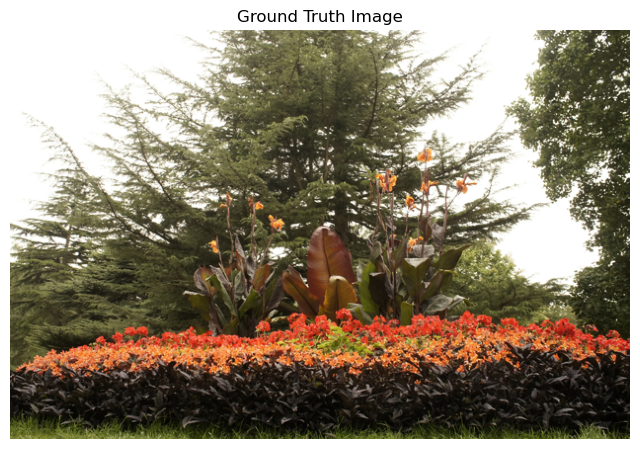

In [33]:
%matplotlib inline
     
gt = vis_cam.original_image[0:3, :, :].unsqueeze(0)
gt_np = gt.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

# Display using imshow
plt.figure(figsize=(8, 6))
plt.imshow(gt_np)
plt.title("Ground Truth Image")
plt.axis('off')
plt.show()



In [40]:
def plot_losses(losses=[], window_size=100):
    plt.figure(figsize=(10, 6))
    
    # Plot the original loss values
    plt.plot(losses, label='Finetuning loss', alpha=0.5)
    
    # Calculate a moving average for the trend line
    if len(losses) >= window_size:
        moving_average = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        trend_iterations = range(len(moving_average))
        plt.plot(trend_iterations, moving_average, label='Trend line (Moving Average)', color='orange', linewidth=2)
    
    # Labels and title
    plt.xlabel('Iteration')
    plt.ylabel('Finetuning loss')
    plt.title('Finetuning loss Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

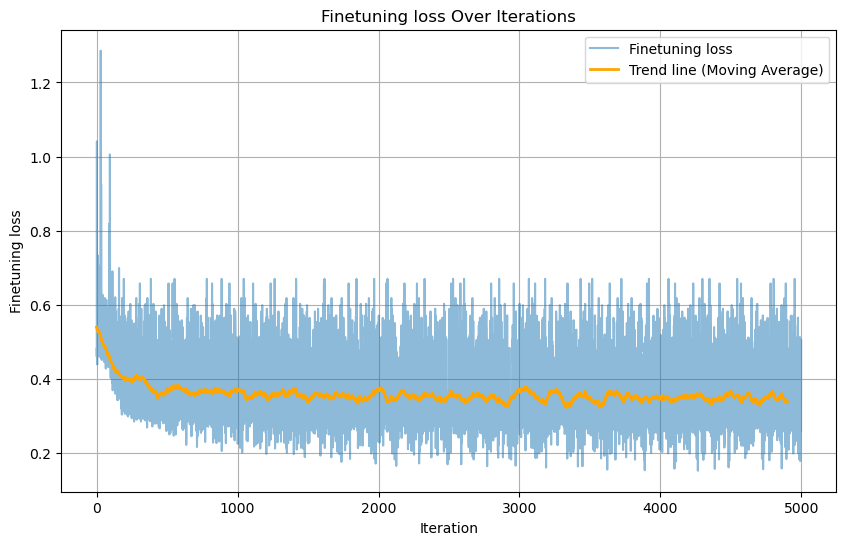

In [43]:
%matplotlib inline

window_size = 100

plot_losses(losses, window_size)

## Step 4: Storage

In [56]:
input_model_dir = "input_models/flower_hq"

total_size = sum(os.path.getsize(os.path.join(input_model_dir, f)) for f in os.listdir(input_model_dir) if os.path.isfile(os.path.join(input_model_dir, f)))
input_size = total_size / (1024 ** 2)
print(f"Total size of the input model: {input_size:.2f} MB")

Total size of the input model: 354.23 MB


In [57]:
out_file = path.join(
    comp_params.output_vq,
    f"point_cloud/iteration_{iteration}/point_cloud.npz",
)

start_time = time.time()
gaussians.save_npz(out_file, sort_morton=not comp_params.not_sort_morton)
end_time = time.time()

timings["encode"] = end_time-start_time
timings["total"] = sum(timings.values())

with open(f"{comp_params.output_vq}/times.json","w") as f:
    json.dump(timings,f)
file_size = os.path.getsize(out_file) / 1024**2
print(f"saved vq finetuned model to {out_file}")
print(f"File size of the output model = {file_size:.2f}MB")

sizes = [input_size, file_size]

saved vq finetuned model to ./output/point_cloud/iteration_35000/point_cloud.npz
File size of the output model = 4.01MB


In [59]:
def visualise_timings(timings=[]):
    plt.figure(figsize=(14, 6))
    timing_keys = list(timings.keys())
    timing_values = list(timings.values())
    plt.bar(timing_keys, timing_values)
    plt.ylabel("Time (seconds)")
    plt.title("Time Spent on Each Step")

    plt.tight_layout()
    plt.show()

In [ ]:
def visualise_storage_metrics(sizes=[]):
    labels = ['Input Model', 'Compressed Model']

    # Plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, sizes, color=['skyblue', 'orange'])
    plt.ylabel("Size (MB)")
    plt.title("Comparison of Input Model and Compressed Model Sizes")

    # Left bar
    bar, size = bars[0], sizes[0]
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 20, f"{size:.2f} MB", ha='center', va='bottom', fontsize=10)

    # Right bar
    bar, size = bars[1], sizes[1]
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, f"{size:.2f} MB", ha='center', va='bottom', fontsize=10)

    plt.show()

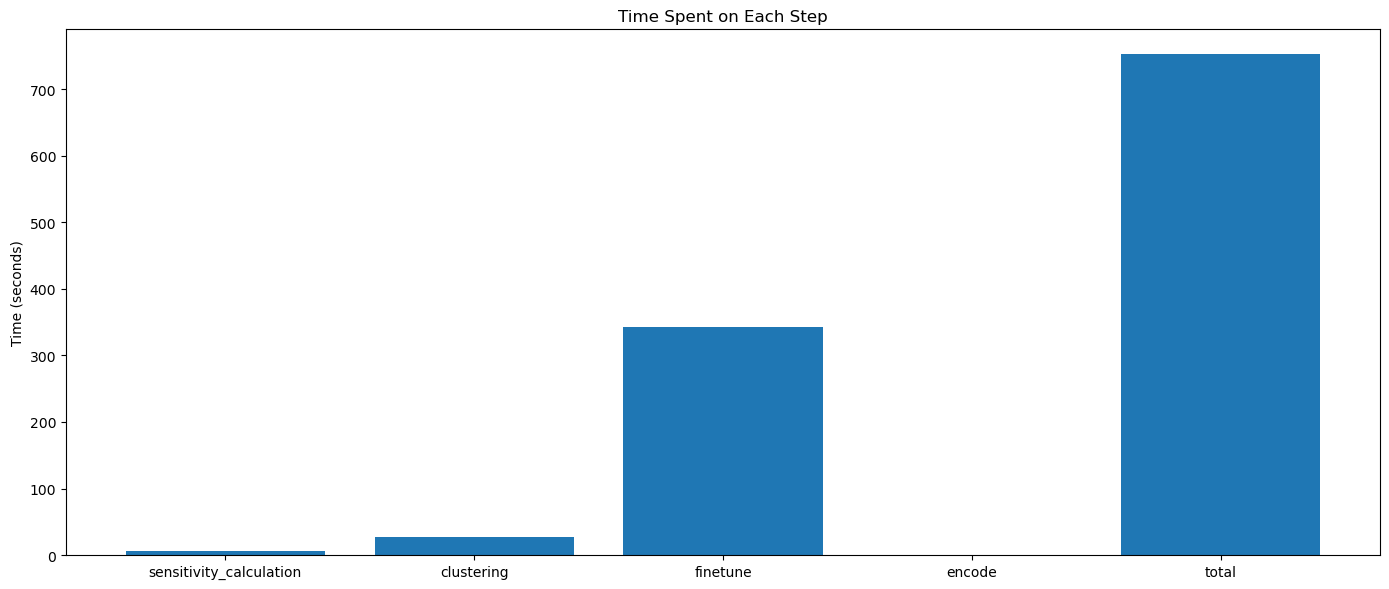

In [61]:
visualise_timings(timings)

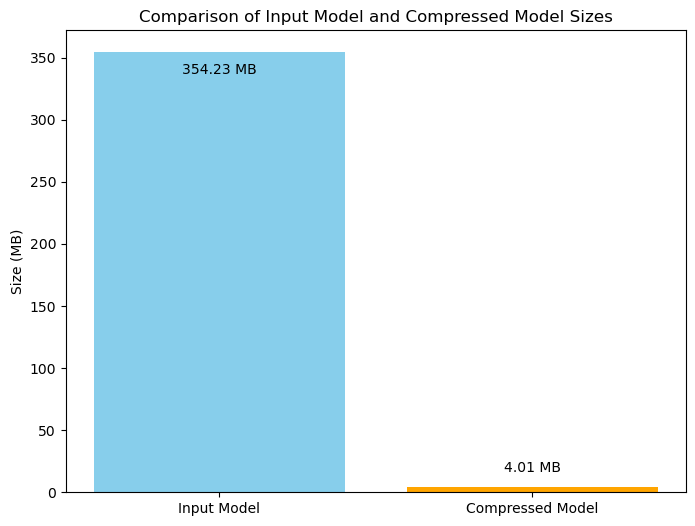

In [74]:
visualise_storage_metrics(sizes)